In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import Counter

import pandas as pd
import numpy as np
from scipy import ndimage, signal
from scipy.linalg import cho_solve, solve_triangular

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from world_rowing import api, livetracker, utils, predict

data_store = 'live_tracker.h5'

In [3]:
with pd.HDFStore(data_store) as store:
    df_names = store.keys()
    races = store['races']
    events = store['events']
    competitions = store['competitions']
    race_results = store['race_results'].reset_index(0)
    
races = utils.merge(
    (races.reset_index(), events, competitions, api.get_boat_types()),
    how='left',
    left_on=('eventId', 'competitionId', 'boatClassId'),
    right_on='id',
    suffixes=(
        (None, '_event'),
        (None, '_competition'),
        (None, '_boat_class')
    )
)

races['full_name'] = races.DisplayName_competition.str.cat(
    [
        races.DisplayName_event,
        races.DisplayName
    ],
    sep='/'
)
race_names = races.set_index('full_name').id

livetracker_names = [f for f in df_names if 'livetracker' in f]
with pd.HDFStore(data_store) as store:
    livetracker_data = {
        f[13:]: store[f] for f in livetracker_names
    }
    
keep_cols = [
    'currentPosition', 'distanceTravelled', 'distanceFromLeader',
    'strokeRate', 'metrePerSecond'
]

race_results['total_seconds'] = race_results.ResultTime.dt.total_seconds()
race_class = races.set_index('id').DisplayName_boat_class

est_times = {}
rec_times = {}
race_live_data = {}
for race_name, live_data in tqdm(livetracker_data.items()):
    race_id = race_names[race_name]
    if race_id in race_results.index:
        est_times[race_id] = live_data.iloc[-1].unstack(0).time.sort_index()
        rec_times[race_id] = race_results.loc[race_id].set_index('Country').total_seconds
        diffs = est_times[race_id] - rec_times[race_id]
        if (abs(diffs.mean()) < 2) and (diffs.std() < 1):
            gmt = api.find_world_best_time(
                boat_class=race_class[race_id]
            ).ResultTime.total_seconds()
            race_live_data[race_id] = livetracker.calculate_pgmts(
                live_data[keep_cols].copy(), gmt
            )
    
live_races = races.loc[
    races.id.isin(race_live_data)
].set_index('id')
    
len(race_live_data)

  0%|          | 0/378 [00:00<?, ?it/s]

208

In [ ]:
(race_id, live_data) = next(iter(race_live_data.items()))

In [ ]:
predict.calc_boat_pace(live_data)

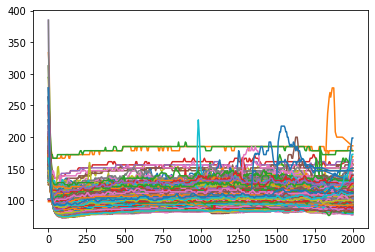

In [10]:
distances = np.linspace(0, 2000, 401).astype(int)
boat_pace = predict.calc_all_boat_pace(race_live_data)
plt.plot(
    distances, boat_pace.values.T
);

<AxesSubplot:ylabel='Density'>

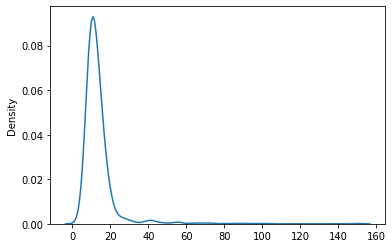

In [11]:
max_variation = np.abs(
    boat_pace.loc[:, 100:].mean(1).values[:, None]
    - boat_pace.loc[:, 100:]
).max(1)
sns.kdeplot(max_variation)

# Gaussian Process prediction 

In [97]:
X = boat_pace.loc[max_variation < 30].values
meanX = X.mean(0, keepdims=True)

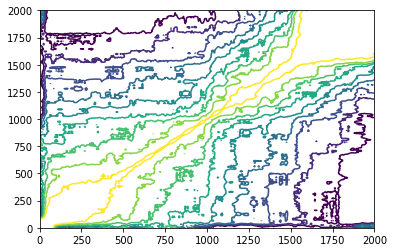

In [98]:
scaledX = X - X.mean(1, keepdims=True)/meanX.mean() * meanX
cov = np.cov(scaledX.T)
plt.contour(
    distances, distances,
    cov,
    np.quantile(cov, np.linspace(0, 1, 11)[1:-1])
)

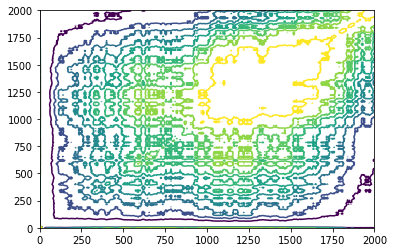

In [99]:
scaledX = X - meanX
cov = np.cov(scaledX.T)
ff = meanX * meanX.T
plt.contour(
    distances, distances,
    cov,
    np.quantile(cov, np.linspace(0, 1, 11)[1:-1])
)

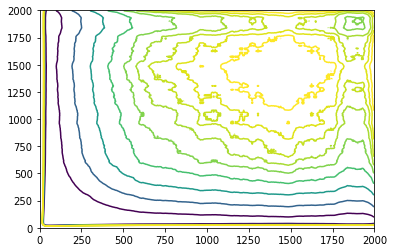

In [100]:
ff = meanX * meanX.T
plt.contour(
    distances, distances,
    ff,
    np.quantile(ff, np.linspace(0, 1, 11)[1:-1])
)

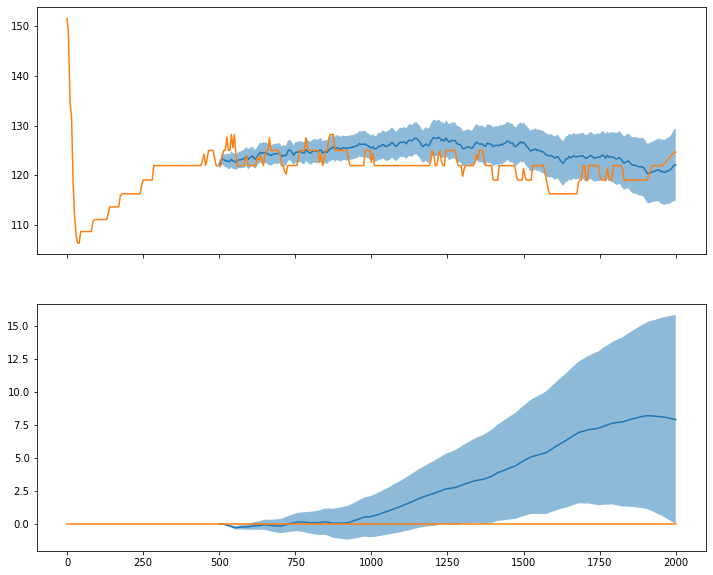

In [105]:
i = 100
x = X[0]
x_fit = distances[:i]
y_fit = x[:i]

f = signal.savgol_filter(meanX, 21,  2)
ff = f * f.T
ff = meanX * meanX.T
Kfull = (ff + cov) + np.eye(len(ff)) * 0.1
# Kfull = ndimage.gaussian_filter(Kfull, sigma=0.1, order=0)
# Kfull = ndimage.gaussian_filter(Kfull, sigma=.3, order=0)
K = Kfull[:i,:i]
L = np.linalg.cholesky(K)
kx = Kfull[i:, :i]
Kxx = Kfull[i:, i:]

y_pred = kx.dot(cho_solve((L, True), y_fit))
S_pred = Kxx - kx.dot(cho_solve((L, True), kx.T))
K2 = linalg.solve_triangular(L, kx.T, lower=True) 
S_pred = Kxx - K2.T.dot(K2)

f, axes = plt.subplots(2, figsize=(12, 10), sharex=True)

axes[0].plot(distances[i:], y_pred)
axes[0].fill_between(
    distances[i:], 
    y_pred + S_pred.diagonal()**0.5, 
    y_pred - S_pred.diagonal()**0.5, 
    alpha=0.5
)
axes[0].plot(distances, x)

times = x.cumsum()/100
triu = np.triu(np.ones_like(S_pred))/100
t_pred = y_pred.dot(triu) + times[i-1]
St = triu.T.dot(S_pred).dot(triu)

axes[1].plot(distances[i:], t_pred - times[i:])
axes[1].fill_between(
    distances[i:], 
    t_pred - times[i:]  - St.diagonal()**0.5, 
    t_pred - times[i:]  + St.diagonal()**0.5,
    alpha=0.5
)
axes[1].plot(distances, np.zeros_like(distances))

In [157]:
def predict(pred_distances, pace, K, L=None, noise=0):
    x = pred_distances
    X = pace.index
    
    kxx = K.loc[x, x]
    kxX = K.loc[x, X]
    KXX = K.loc[X, X] + np.eye(len(X)) * noise
    if L is None:
        L = pd.DataFrame(
            np.linalg.cholesky(KXX),
            index=KXX.index,
            columns=KXX.columns, 
        ) 
    else:
        L = L.loc[X,X]
    
    pred_pace = kxX.dot(linalg.cho_solve((L, True), pace))
    Kkh = linalg.solve_triangular(
        L, kxX.T, lower=True
    )
    pred_pace_cov = kxx - Kkh.T.dot(Kkh)
    
    deltam = np.diff(pred_distances)
    triu = np.triu(
        np.ones_like(kxx) * np.r_[deltam, deltam[0]]
    )/500
    pred_times = pred_pace.dot(triu)
    pred_times_cov = triu.T.dot(pred_pace_cov).dot(triu)
    
    return pred_pace, pred_pace_cov, pred_times, pred_times_cov

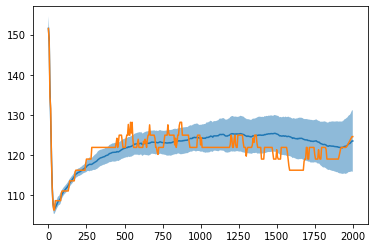

In [162]:
i = 50
x = X[0]

ff = meanX * meanX.T
K = pd.DataFrame(
    (ff + cov), 
    index=distances, columns=distances
)
pace = pd.Series(x, index=distances)
pred, pred_cov, pred_times, pred_times_cov = \
    predict(distances, pace.iloc[:i], K, noise=10.)
pred_std = pred_cov.values.diagonal()**0.5
pred_time_std = pred_times_cov.diagonal()**0.5

plt.plot(pred)
plt.fill_between(
    distances, 
    pred - pred_std,
    pred + pred_std,
    alpha=0.5
)
plt.plot(distances, x)

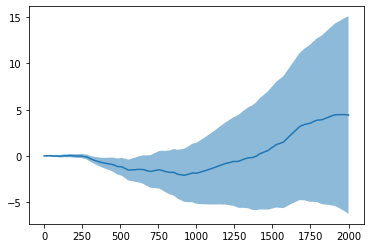

In [163]:
times = x.cumsum()/100
plt.plot(distances, pred_times - times)
plt.fill_between(
    distances, 
    pred_times - times - pred_time_std,
    pred_times - times + pred_time_std,
    alpha=0.5
)

In [141]:
pred_cov.values.diagonal()

array([ 0.00000000e+00,  0.00000000e+00, -3.63797881e-12,  0.00000000e+00,
        0.00000000e+00,  3.63797881e-12, -1.81898940e-12, -1.81898940e-12,
        0.00000000e+00,  3.63797881e-12, -3.63797881e-12, -1.81898940e-12,
       -1.81898940e-12, -5.45696821e-12,  0.00000000e+00, -3.63797881e-12,
       -5.45696821e-12,  7.27595761e-12,  1.81898940e-12,  1.81898940e-12,
       -3.63797881e-12, -3.63797881e-12,  3.63797881e-12, -3.63797881e-12,
       -1.09139364e-11,  1.81898940e-12, -3.63797881e-12, -7.27595761e-12,
        3.63797881e-12, -3.63797881e-12, -1.09139364e-11, -7.27595761e-12,
        9.09494702e-12,  1.27329258e-11,  5.45696821e-12, -1.81898940e-12,
        5.45696821e-12, -5.45696821e-12, -7.27595761e-12, -5.45696821e-12,
       -5.45696821e-12, -1.45519152e-11,  1.09139364e-11, -3.63797881e-12,
        5.45696821e-12,  5.45696821e-12,  1.81898940e-12, -1.09139364e-11,
       -7.27595761e-12,  0.00000000e+00, -1.81898940e-12,  0.00000000e+00,
       -3.63797881e-12,  

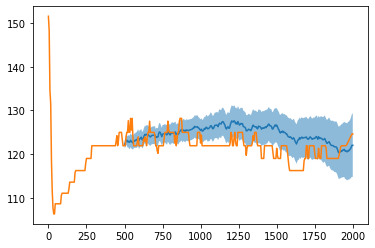

## Boat class specific GPs 

In [5]:
from scipy import linalg

In [12]:
sel_boat_pace = boat_pace.loc[max_variation < 30]
sel_race_ids = sel_boat_pace.index.get_level_values(0).unique()
race_boat_class = live_races.loc[sel_race_ids].DisplayName_boat_class
grouped_live_races = race_boat_class.groupby(race_boat_class)

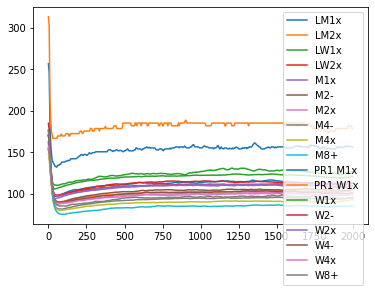

In [13]:
boat_mean_pace = {}
boat_shifted_pace = {}

for boat_class, boat_df in grouped_live_races:
    class_boat_pace = sel_boat_pace.loc[boat_df.index]
    boat_mean_pace[boat_class] = class_boat_pace.mean(0)
    boat_shifted_pace[boat_class] = (
        class_boat_pace - class_boat_pace.mean(0)
    )
#     break
    
for boat_class, mean_pace in boat_mean_pace.items():
    plt.plot(distances, mean_pace, label=boat_class)
    
plt.legend()

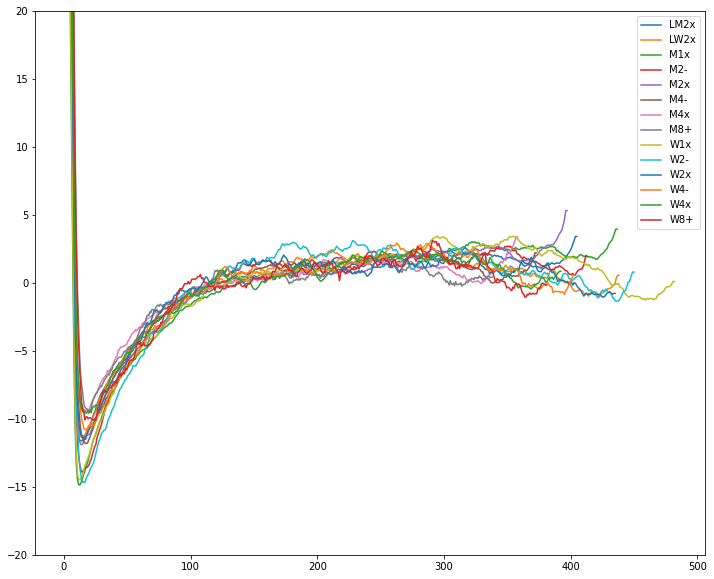

In [196]:
f, ax = plt.subplots(figsize=(12, 10))


for boat_class, mean_pace in boat_mean_pace.items():
    if boat_class not in ('LW1x', 'LM1x', 'PR1 M1x', 'PR1 W1x'):
        plt.plot(mean_pace.cumsum()/100, 
                 mean_pace - (mean_pace[:]).mean(), 
                 label=boat_class)
    
plt.ylim(-20, 20)
plt.legend()

In [164]:
shifted_pace = pd.concat(boat_shifted_pace)
cov = shifted_pace.cov()

In [165]:
boat_mean_K = {
    boat_class: pd.DataFrame(
        mean_pace.values[:, None] * mean_pace.values[None, :],
        index=mean_pace.index,
        columns=mean_pace.index, 
    )
    for boat_class, mean_pace in boat_mean_pace.items()
}
boat_K = {
    boat_class: cov + meanK
    for boat_class, meanK in boat_mean_K.items()
}

In [178]:

# boat_L = {
#     boat_class: pd.DataFrame(
#         np.linalg.cholesky(
#             cov + meanK 
#         ),
#         index=mean_pace.index,
#         columns=mean_pace.index, 
#     ) 
#     for boat_class, meanK in boat_mean_K.items()
# }

LinAlgError: Matrix is not positive definite

In [90]:
def predict(pred_distances, pace, K, L=None):
    x = pred_distances
    X = pace.index
    
    kxx = K.loc[x, x]
    kxX = K.loc[x, X]
    KXX = K.loc[X, X]
    if L is None:
        LXX = pd.DataFrame(
            np.linalg.cholesky(KXX),
            index=mean_pace.index,
            columns=mean_pace.index, 
        ) 
    else:
        L = L.loc[X,X]
    
    pred_pace = kxX.dot(linalg.cho_solve((L, True), pace))
    Kkh = linalg.solve_triangular(
        L, kxX.T, lower=True
    )
    pred_cov = kxx - Kkh.T.dot(Kkh)
    return pred_pace, pred_cov
    
    

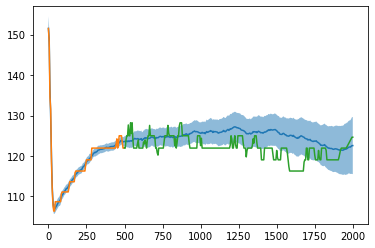

In [183]:
i = 100
pace = sel_boat_pace.iloc[0, :]
race_id, cnt = pace.name
boat_class = race_boat_class[race_id]
pred_distances = distances[:]
K = boat_K[boat_class]
# L = boat_L[boat_class]

pred, pred_cov, pred_times, pred_times_cov = \
    predict(pred_distances, pace.iloc[:i], K, noise=10.)
pred_std = pred_cov.values.diagonal()**0.5
pred_time_std = pred_times_cov.diagonal()**0.5

plt.plot(pred)
plt.fill_between(
    pred_distances, 
    pred - pred_std,
    pred + pred_std,
    alpha=0.5
)
plt.plot(pace.iloc[:i])
plt.plot(pace.iloc[i:])

## GP smoothing

In [ ]:
K = (ff + cov)
Kfull = K + np.eye(len(ff)) * 100
L = np.linalg.cholesky(Kfull)

X_smoothed = np.vstack([
    K.dot(cho_solve((L, True), x))
    for x in X
])
Xsmean = X_smoothed.mean(0, keepdims=True)
cov = np.cov((X_smoothed - Xsmean).T)
ff = Xsmean * Xsmean.T

plt.contour(
    distances, distances,
    cov,
    np.quantile(cov, np.linspace(0, 1, 11)[1:-1])
)

In [ ]:
np.cov?

# Derviative regularised Factor Analysis 

In [ ]:
i = 20
x = X[200]

K = (ff + cov)
Kfull = K + np.eye(len(ff)) * 100
L = np.linalg.cholesky(Kfull)

x_smoothed = K.dot(cho_solve((L, True), x))

plt.plot(distances, x)
plt.plot(distances, x_smoothed)

In [ ]:
W, F = predict.fit_factor_analysis_regularised(X, 5)
plt.plot(ds, W.dot(F).T);